Idea: 

investigate the dependence of N, S and M on the time taken to reach a stable mapping. Run MC simulations for many iterations to see how long it takes for A to reach a threshold value.

Also sanity check: maybe do this without numba first, to then make sure it performs as expected.

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from numba import jit, njit
from numba.types import float64, int64
from general_functions import *
from scipy.optimize import curve_fit

plt.style.use('default')

plotdir = '/Users/casimirfisch/Desktop/Uni/MPhys/code/plots/equilibration parameters/'
filesdir = '/Users/casimirfisch/Desktop/Uni/MPhys/code/files/parameter dependence/'

In [15]:
def initiate_values():
    if len(sys.argv) != 5:
        N, S, M = 4, 3, 6
        lambd = 0.01 # small-but-not-too-small
    else:
        N = int(sys.argv[1])
        S = int(sys.argv[2])
        M = int(sys.argv[3])
        lambd = float(sys.argv[4])

    return N, S, M, lambd

@njit
def rand_choice_numba(prob):
    return np.searchsorted(np.cumsum(prob), np.random.random(), side="right")

@jit(float64[:](float64[:], int64, float64[:]),nopython=True)
def round_numba(x, decimals, out):
    return np.round_(x, decimals, out)

@njit
def intelligibility_numba(phi, N, S, M):

    A = 0
    for i in range(N):
        for j in range(N):
            if j == i: continue
            psi_j = np.divide(phi[j,:,:], np.expand_dims(phi[j,:,:].sum(axis=1), -1)) # [:, np.newaxis]
            for m in range(M):
                for s in range(S):
                    A += 1/(N * (N-1) * M) * phi[i, s, m] * psi_j[s, m]
    return A

@njit
def equilibrium_numba(phi, N, S, M, threshold=0.95, decision=False, decision_frac=0.3):

    I = intelligibility_numba(phi, N, S, M)
    if decision: return I > 1/M * (1 + decision_frac)
    else:
        if M >= S: return (I > threshold * (S/M))
        else: return (I > threshold)

@njit
def time_to_equilibrium(N, S, M, lambd, max_steps=1e8, n_runs=10, decision=False):

    eq_times = []
    for run in range(n_runs):

        phi = np.ones((N, S, M)) / S # phi = 1/S for all speakers

        for step in range(max_steps):

            intend = np.random.randint(M) # meaning intended -- rho = 1/M, uniform distribution
            speaker = np.random.randint(N)
            listener = np.random.randint(N)
            while listener == speaker: listener = np.random.randint(N)

            produce = rand_choice_numba(prob = phi[speaker,:,intend])
            infer = rand_choice_numba(prob = phi[listener,produce,:] / np.sum(phi[listener,produce,:]))
            # updating phi
            feedback = lambd if infer == intend else - lambd
            phi[speaker,produce,intend] += (feedback * phi[speaker,produce,intend] * (1 - phi[speaker,produce,intend]))
            phi[speaker,:,intend] /= np.sum(phi[speaker,:,intend]) # normalise along signal axis

            if step % 1000 == 0 and step > 0:

                if equilibrium_numba(phi, N, S, M, decision=decision): 
                    eq_times.append(step)
                    break

        if step == max_steps - 1: # no equilibration
            return None

    return eq_times

In [55]:
# show the intellibility plot of a single run, highlighting the threshold used for the hesitation time

def run_model_hesitation(N=2, S=3, M=3, lambd=0.01, max_steps=1_000_000, thresh_frac=0.3, eq=False):

    mu_pos, mu_neg = lambd, -lambd
    I_list, timesteps = [], []

    phi = initiate_phi(N, S, M)

    for i in range(max_steps):

        speaker, listener = choose_agents(N)
        intend = choose_meaning(M)
        signal = choose_signal(S, prob_array=phi[speaker,:,intend])
        infer = infer_meaning(M, prob_array=phi[listener,signal,:] / np.sum(phi[listener,signal,:]))
        feedback = get_feedback(mu_pos, mu_neg, intend, infer, M)

        phi[speaker,signal,intend] += feedback * U(phi[speaker,signal,intend])
        phi[speaker,:,intend] /= np.sum(phi[speaker,:,intend])

        if i % 500 == 0:

            I = intelligibility(phi, N, S, M)
            I_list.append(I)
            timesteps.append(i)

            if eq and equilibrium(phi, N, S, M, I=I, thresh_frac=0.95): 
                print('equilibrium reached')
                break

    return timesteps, I_list

def plot_hesitations_N(thresh_frac=0.3):

    S, M, lambd = 5, 5, 0.1

    fig, ax = plt.subplots()

    for N in range(2,6):
        print(N)
        timesteps, I_list = run_model_hesitation(N, S, M, lambd, thresh_frac=thresh_frac, max_steps=30000)
        ax.plot(timesteps, I_list, label=f'N = {N}')

    ax.axhline(y=1/M*(1+thresh_frac), color='k', alpha=0.7, ls='dashed')
    ax.set_ylabel('intelligibility')
    ax.set_xlabel('timesteps')
    ax.legend()
    plt.show()

def plot_hesitations_M(thresh_frac=0.3):

    N, S, lambd = 2, 5, 0.1

    fig, ax = plt.subplots()

    for M in range(5,8):
        print('M =', M)
        timesteps, I_list = run_model_hesitation(N, S, M, lambd, thresh_frac=thresh_frac, max_steps=50000)
        ax.plot(timesteps, I_list, label=f'M = {M}')
        # ax.axhline(y=1/M*(1+thresh_frac), color='k', alpha=0.7, ls='dashed')
    
    ax.set_ylabel('intelligibility')
    ax.set_xlabel('timesteps')
    ax.legend()
    plt.show()

M = 5
M = 6
M = 7


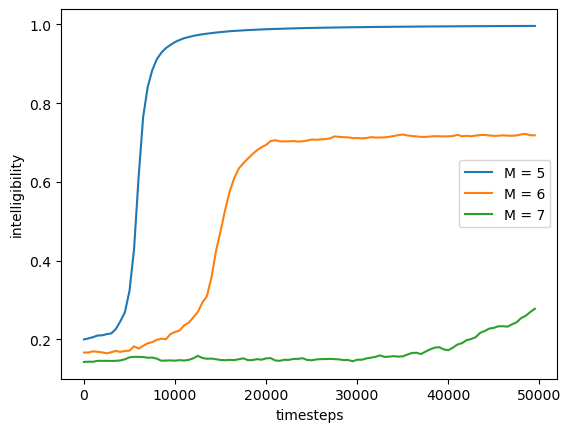

In [56]:
plot_hesitations_M()

In [16]:
# dependence of N

decision = True
string = 'decision' if decision else 'equilibrium'

S, M, lambd, n_runs = 3, 3, 0.1, 100
Ns = np.arange(2, 16)
avg_times, error_bars = [], []

for N in Ns:
    eq_times = time_to_equilibrium(N, S, M, lambd, n_runs=n_runs, decision=decision)
    avg_time, std = np.mean(eq_times), np.std(eq_times)

    print(f'N = {N}\naverage {string} time = {int(avg_time)} ± {std:.1f} steps')
    avg_times.append(avg_time)
    error_bars.append(std/np.sqrt(n_runs))

f = open(filesdir+f'N-dep-{string}.txt', 'w')
for i in range(len(avg_times)):
    f.write(f'{Ns[i]} {avg_times[i]} {error_bars[i]}\n')

f.close()

N = 2
average decision time = 1430 ± 495.1 steps
N = 3
average decision time = 2130 ± 364.8 steps
N = 4
average decision time = 2920 ± 594.6 steps
N = 5
average decision time = 3660 ± 696.0 steps
N = 6
average decision time = 4280 ± 837.6 steps
N = 7
average decision time = 5330 ± 1086.8 steps
N = 8
average decision time = 6270 ± 1215.4 steps
N = 9
average decision time = 6740 ± 1300.9 steps
N = 10
average decision time = 7840 ± 1398.0 steps
N = 11
average decision time = 8670 ± 1772.3 steps
N = 12
average decision time = 9220 ± 1487.1 steps
N = 13
average decision time = 10550 ± 1651.5 steps
N = 14
average decision time = 11390 ± 1989.4 steps
N = 15
average decision time = 12190 ± 2072.2 steps


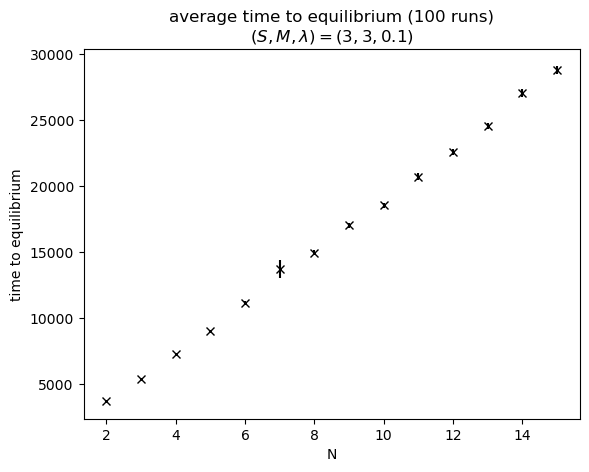

In [82]:
fig, ax = plt.subplots()
ax.errorbar(Ns, avg_times, yerr=error_bars, marker='x', color='k', ls='none')
ax.set_xlabel('N')
ax.set_ylabel(f'time to {string}')

ax.set_title(f'average time to {string} ({n_runs} runs)\n$(S,M,\lambda) = ({S},{M},{lambd})$')
fig.savefig(plotdir + f'dependence-N-{string}.png')
plt.show()

In [83]:
# dependence of M

decision = True
string = 'decision' if decision else 'equilibrium'

N, S, lambd, n_runs = 2, 3, 0.1, 100
Ms = np.arange(3, 11)
avg_times, error_bars = [], []

for M in Ms:
    eq_times = time_to_equilibrium(N, S, M, lambd, n_runs=n_runs, decision=decision)
    avg_time, std = np.mean(eq_times), np.std(eq_times)

    print(f'M = {M}\naverage {string} time = {int(avg_time)} ± {int(std)} steps')
    avg_times.append(avg_time)
    error_bars.append(std/np.sqrt(n_runs))

f = open(filesdir+f'M-dep-{string}.txt', 'w')
for i in range(len(avg_times)):
    f.write(f'{Ms[i]} {avg_times[i]} {error_bars[i]}\n')

f.close()

M = 3
average decision time = 1380 ± 485 steps
M = 4
average decision time = 2300 ± 458 steps
M = 5
average decision time = 3750 ± 852 steps
M = 6
average decision time = 5860 ± 1349 steps
M = 7
average decision time = 9600 ± 3046 steps
M = 8
average decision time = 16630 ± 4892 steps
M = 9
average decision time = 41570 ± 20706 steps
M = 10
average decision time = 202410 ± 139672 steps


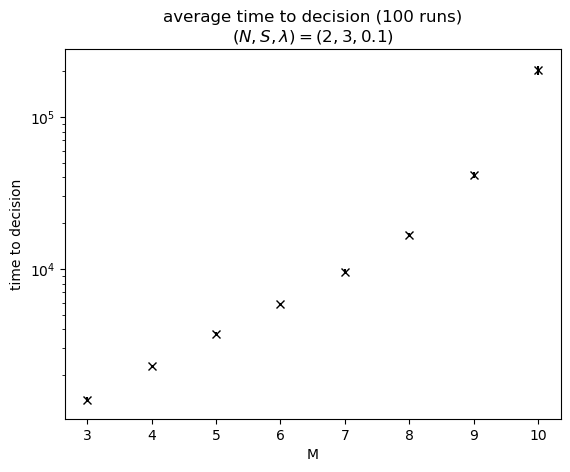

In [84]:
fig, ax = plt.subplots()
ax.errorbar(Ms, avg_times, yerr=error_bars, marker='x', color='k', ls='none')
ax.set_xlabel('M')
ax.set_ylabel(f'time to {string}')
ax.set_yscale('log')

ax.set_title(f'average time to {string} ({n_runs} runs)\n$(N,S,\lambda) = ({N},{S},{lambd})$')
fig.savefig(plotdir + f'dependence-M-{string}.png')
plt.show()

In [17]:
# dependence of S

decision = True
string = 'decision' if decision else 'equilibrium'

N, M, lambd, n_runs = 2, 3, 0.1, 100
Ss = np.arange(3, 16)
avg_times, error_bars = [], []

for S in Ss:
    eq_times = time_to_equilibrium(N, S, M, lambd, n_runs=n_runs, decision=decision)
    avg_time, std = np.mean(eq_times), np.std(eq_times)

    print(f'S = {S}\naverage {string} time = {int(avg_time)} ± {std:.1f} steps')
    avg_times.append(avg_time)
    error_bars.append(std/np.sqrt(n_runs))
    
f = open(filesdir+f'S-dep-{string}.txt', 'w')
for i in range(len(avg_times)):
    f.write(f'{Ss[i]} {avg_times[i]} {error_bars[i]}\n')

f.close()

S = 3
average decision time = 1390 ± 507.8 steps
S = 4
average decision time = 1600 ± 489.9 steps
S = 5
average decision time = 1670 ± 470.2 steps
S = 6
average decision time = 1890 ± 312.9 steps
S = 7
average decision time = 1970 ± 262.9 steps
S = 8
average decision time = 1990 ± 172.9 steps
S = 9
average decision time = 2140 ± 347.0 steps
S = 10
average decision time = 2110 ± 312.9 steps
S = 11
average decision time = 2200 ± 400.0 steps
S = 12
average decision time = 2420 ± 493.6 steps
S = 13
average decision time = 2500 ± 500.0 steps
S = 14
average decision time = 2660 ± 514.2 steps
S = 15
average decision time = 2840 ± 463.0 steps


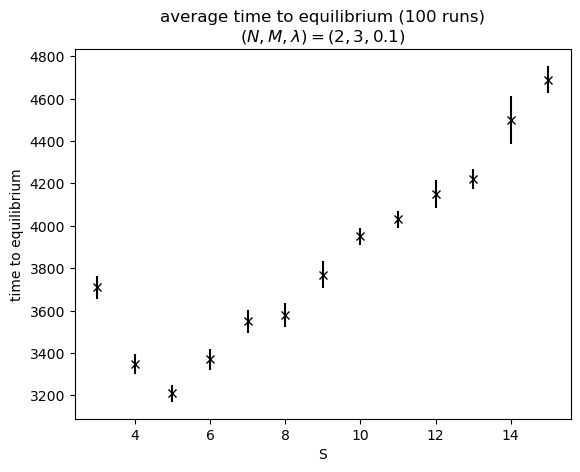

In [86]:
fig, ax = plt.subplots()
ax.errorbar(Ss, avg_times, yerr=error_bars, marker='x', color='k', ls='none')
ax.set_xlabel('S')
ax.set_ylabel(f'time to {string}')

ax.set_title(f'average time to {string} ({n_runs} runs)\n$(N,M,\lambda) = ({N},{M},{lambd})$')
fig.savefig(plotdir + f'dependence-S-{string}.png')
plt.show()

In [18]:
# dependence of lambda

decision = True
string = 'decision' if decision else 'equilibrium'

N, S, M, n_runs = 2, 3, 3, 100
lambdas = np.geomspace(0.001, 0.1, 10)
avg_times, error_bars = [], []
for lambd in lambdas:
    eq_times = time_to_equilibrium(N, S, M, lambd, n_runs=n_runs)
    avg_time, std = np.mean(eq_times), np.std(eq_times)

    print(f'lambda = {lambd:.2e}\naverage {string} time = {int(avg_time)} ± {int(std)} steps')
    avg_times.append(avg_time)
    error_bars.append(std/np.sqrt(n_runs))

f = open(filesdir+f'lambda-dep-{string}.txt', 'w')
for i in range(len(avg_times)):
    f.write(f'{lambdas[i]} {avg_times[i]} {error_bars[i]}\n')

f.close()

lambda = 1.00e-03
average decision time = 437240 ± 38752 steps
lambda = 1.67e-03
average decision time = 253460 ± 22044 steps
lambda = 2.78e-03
average decision time = 144750 ± 10770 steps
lambda = 4.64e-03
average decision time = 85870 ± 7067 steps
lambda = 7.74e-03
average decision time = 49910 ± 4647 steps
lambda = 1.29e-02
average decision time = 29320 ± 3483 steps
lambda = 2.15e-02
average decision time = 16950 ± 1699 steps
lambda = 3.59e-02
average decision time = 9980 ± 948 steps
lambda = 5.99e-02
average decision time = 6250 ± 1608 steps
lambda = 1.00e-01
average decision time = 3670 ± 510 steps


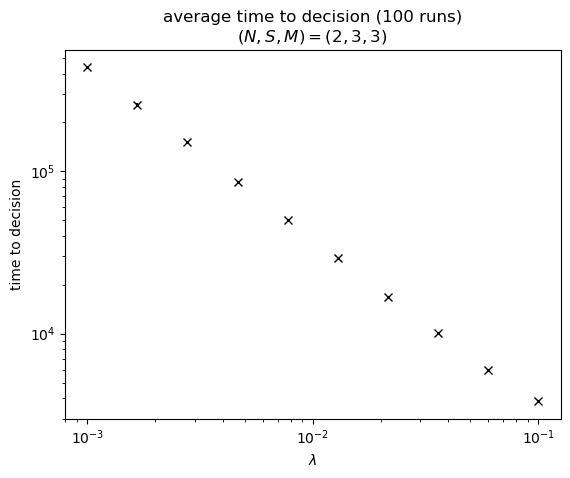

In [14]:
fig, ax = plt.subplots()
ax.errorbar(lambdas, avg_times, yerr=error_bars, marker='x', color='k', ls='none')
ax.set_xlabel(f'$\lambda$')
ax.set_ylabel(f'time to {string}')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(f'average time to {string} ({n_runs} runs)\n$(N,S,M) = ({N},{S},{M})$')
fig.savefig(plotdir + f'dependence-lambda-{string}.png')
plt.show()

In [19]:
# dependence on S in square case

decision = True
string = 'decision' if decision else 'equilibrium'

N, lambd, n_runs = 2, 0.1, 10
size = np.arange(3, 9)
avg_times, error_bars = [], []

for S in size:
    M = S
    eq_times = time_to_equilibrium(N, S, M, lambd, n_runs=n_runs, decision=decision)
    if eq_times is None: 
        print('no equilibration')
        continue
    avg_time, std = np.mean(eq_times), np.std(eq_times)

    print(f'S = {S}\naverage {string} time = {int(avg_time)} ± {int(std)} steps')
    avg_times.append(avg_time)
    error_bars.append(std/np.sqrt(n_runs))

f = open(filesdir+f'(M,S)-dep-{string}.txt', 'w')
for i in range(len(avg_times)):
    f.write(f'{size[i]} {avg_times[i]} {error_bars[i]}\n')

f.close()

S = 3
average decision time = 1400 ± 489 steps
S = 4
average decision time = 2900 ± 538 steps
S = 5
average decision time = 4900 ± 1044 steps
S = 6
average decision time = 13100 ± 4182 steps
S = 7
average decision time = 201000 ± 155397 steps
S = 8
average decision time = 7571200 ± 8533521 steps


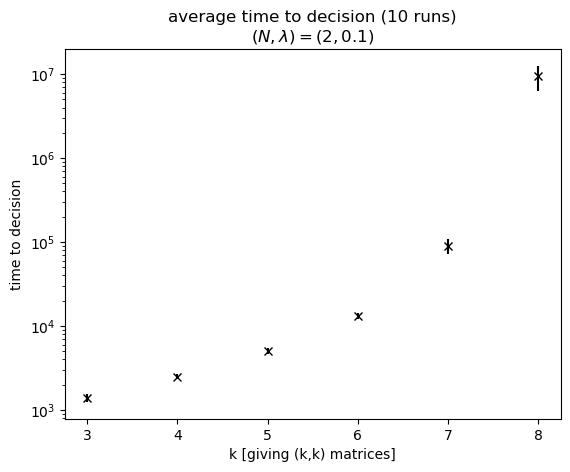

In [7]:
fig, ax = plt.subplots()
ax.errorbar(size, avg_times, yerr=error_bars, marker='x', color='k', ls='none')
ax.set_xlabel('k [giving (k,k) matrices]')
ax.set_ylabel(f'time to {string}')
ax.set_yscale('log')

ax.set_title(f'average time to {string} ({n_runs} runs)\n$(N,\lambda) = ({N},{lambd})$')
fig.savefig(plotdir + f'dependence-(S,M)-{string}.png')
plt.show()

In [11]:
fontsize = 13
figsize=(5,4)

def exponential(x, A, s): return A * np.exp(s*x)
def exponential_quadr(x, A, s, d): return A * np.exp(s*x**d)

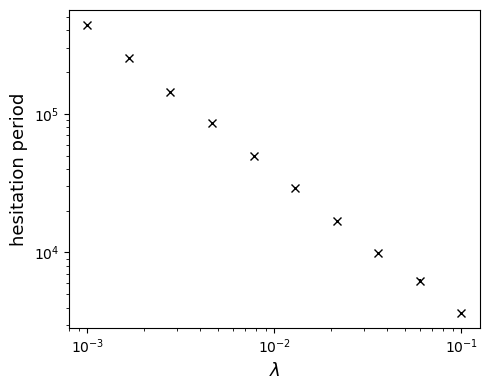

In [12]:
lambds, avg_times, error_bars = np.loadtxt(filesdir+'lambda-dep-decision.txt', unpack=True) # k, avg_times, error_bars

# popt, pcov = curve_fit(exponential, Ms, avg_times, sigma=error_bars)

fig, ax = plt.subplots(tight_layout=True, figsize=figsize)
ax.errorbar(lambds, avg_times, yerr=error_bars, marker='x', color='k', ls='none')
# ax.plot(Ms, exponential(Ms, *popt), 'r', lw=0.5)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(f'$\lambda$', fontsize=fontsize)
ax.set_ylabel('hesitation period', fontsize=fontsize)
fig.savefig(plotdir+'hesitation-lambda.png', dpi=400)

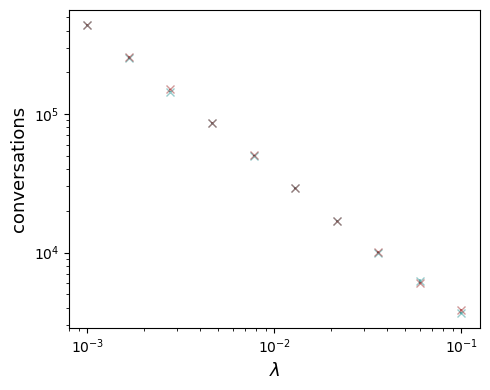

In [17]:
lambds, hes_times, hes_errs = np.loadtxt(filesdir+'lambda-dep-decision.txt', unpack=True)
_     , con_times, con_errs = np.loadtxt(filesdir+'lambda-dep.txt', unpack=True)

# popt, pcov = curve_fit(exponential, Ms, avg_times, sigma=error_bars)

fig, ax = plt.subplots(tight_layout=True, figsize=figsize)
ax.errorbar(lambds, hes_times, yerr=hes_errs, marker='x', color='teal', alpha=0.4, ls='none', label='hesitation')
ax.errorbar(lambds, con_times, yerr=con_errs, marker='x', color='darkred', alpha=0.4, ls='none', label='convergence')
# ax.plot(Ms, exponential(Ms, *popt), 'r', lw=0.5)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(f'$\lambda$', fontsize=fontsize)
ax.set_ylabel('conversations', fontsize=fontsize)
fig.savefig(plotdir+'hesitation-conv-lambda.png', dpi=400)

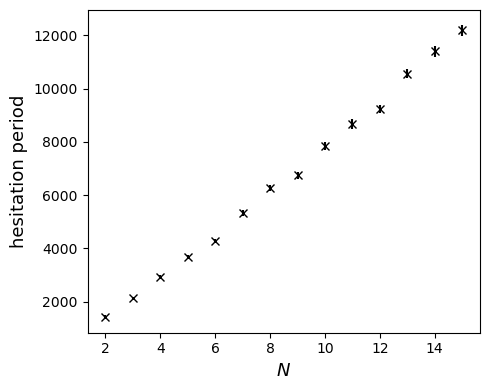

In [13]:
Ns, avg_times, error_bars = np.loadtxt(filesdir+'N-dep-decision.txt', unpack=True) # k, avg_times, error_bars

# popt, pcov = curve_fit(exponential, Ms, avg_times, sigma=error_bars)

fig, ax = plt.subplots(tight_layout=True, figsize=figsize)
ax.errorbar(Ns, avg_times, yerr=error_bars, marker='x', color='k', ls='none')
# ax.plot(Ms, exponential(Ms, *popt), 'r', lw=0.5)
# ax.set_yscale('log')
ax.set_xlabel(f'$N$', fontsize=fontsize)
ax.set_ylabel('hesitation period', fontsize=fontsize)
fig.savefig(plotdir+'hesitation-N.png', dpi=400)

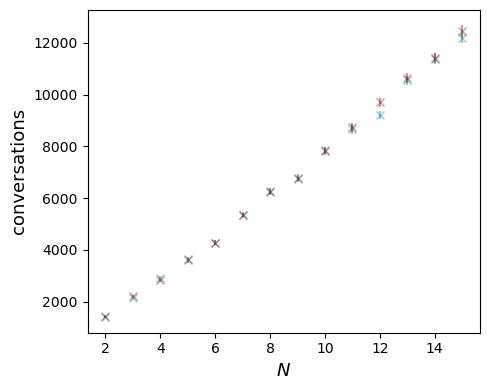

In [20]:
Ns, hes_times, hes_errs = np.loadtxt(filesdir+'N-dep-decision.txt', unpack=True)
_ , con_times, con_errs = np.loadtxt(filesdir+'N-dep.txt', unpack=True)

# popt, pcov = curve_fit(exponential, Ms, avg_times, sigma=error_bars)

fig, ax = plt.subplots(tight_layout=True, figsize=figsize)
ax.errorbar(Ns, hes_times, yerr=hes_errs, marker='x', color='teal', alpha=0.4, ls='none', label='hesitation')
ax.errorbar(Ns, con_times, yerr=con_errs, marker='x', color='darkred', alpha=0.4, ls='none', label='convergence')
# ax.plot(Ms, exponential(Ms, *popt), 'r', lw=0.5)
# ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_ylabel('conversations', fontsize=fontsize)
ax.set_xlabel(f'$N$', fontsize=fontsize)
fig.savefig(plotdir+'hesitation-conv-N.png', dpi=400)

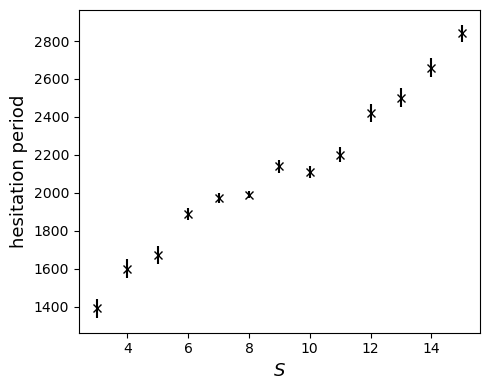

In [14]:
Ss, avg_times, error_bars = np.loadtxt(filesdir+'S-dep-decision.txt', unpack=True) # k, avg_times, error_bars

# popt, pcov = curve_fit(exponential, Ms, avg_times, sigma=error_bars)

fig, ax = plt.subplots(tight_layout=True, figsize=figsize)
ax.errorbar(Ss, avg_times, yerr=error_bars, marker='x', color='k', ls='none')
# ax.plot(Ms, exponential(Ms, *popt), 'r', lw=0.5)
# ax.set_yscale('log')
ax.set_xlabel(f'$S$', fontsize=fontsize)
ax.set_ylabel('hesitation period', fontsize=fontsize)
fig.savefig(plotdir+'hesitation-S.png', dpi=400)


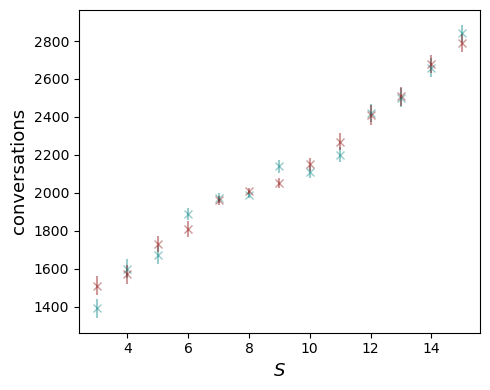

In [23]:
Ss, hes_times, hes_errs = np.loadtxt(filesdir+'S-dep-decision.txt', unpack=True)
_ , con_times, con_errs = np.loadtxt(filesdir+'S-dep.txt', unpack=True)

# popt, pcov = curve_fit(exponential, Ms, avg_times, sigma=error_bars)

fig, ax = plt.subplots(tight_layout=True, figsize=figsize)
ax.errorbar(Ss, hes_times, yerr=hes_errs, marker='x', color='teal', alpha=0.4, ls='none', label='hesitation')
ax.errorbar(Ss, con_times, yerr=con_errs, marker='x', color='darkred', alpha=0.4, ls='none', label='convergence')
# ax.plot(Ms, exponential(Ms, *popt), 'r', lw=0.5)
# ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_ylabel('conversations', fontsize=fontsize)
ax.set_xlabel(f'$S$', fontsize=fontsize)
fig.savefig(plotdir+'hesitation-conv-S.png', dpi=400)

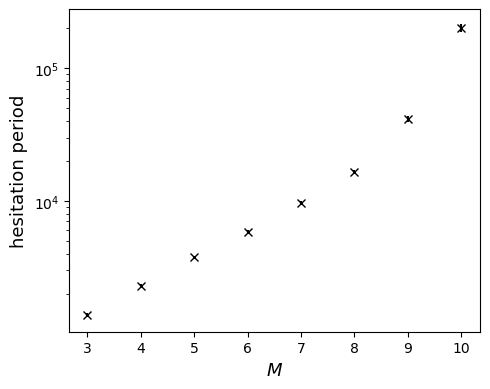

In [15]:
Ms, avg_times, error_bars = np.loadtxt(filesdir+'M-dep-decision.txt', unpack=True) # k, avg_times, error_bars

# popt, pcov = curve_fit(exponential, Ms, avg_times, sigma=error_bars)

fig, ax = plt.subplots(tight_layout=True, figsize=figsize)
ax.errorbar(Ms, avg_times, yerr=error_bars, marker='x', color='k', ls='none')
# ax.plot(Ms, exponential(Ms, *popt), 'r', lw=0.5)
ax.set_yscale('log')
ax.set_xlabel(f'$M$', fontsize=fontsize)
ax.set_ylabel('hesitation period', fontsize=fontsize)
fig.savefig(plotdir+'hesitation-M.png', dpi=400)

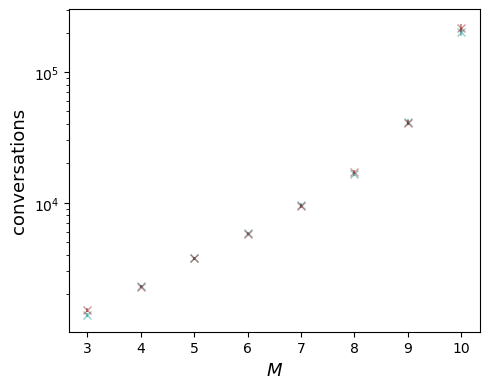

In [25]:
Ms, hes_times, hes_errs = np.loadtxt(filesdir+'M-dep-decision.txt', unpack=True)
_ , con_times, con_errs = np.loadtxt(filesdir+'M-dep.txt', unpack=True)

# popt, pcov = curve_fit(exponential, Ms, avg_times, sigma=error_bars)

fig, ax = plt.subplots(tight_layout=True, figsize=figsize)
ax.errorbar(Ms, hes_times, yerr=hes_errs, marker='x', color='teal', alpha=0.4, ls='none', label='hesitation')
ax.errorbar(Ms, con_times, yerr=con_errs, marker='x', color='darkred', alpha=0.4, ls='none', label='convergence')
# ax.plot(Ms, exponential(Ms, *popt), 'r', lw=0.5)
ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_ylabel('conversations', fontsize=fontsize)
ax.set_xlabel(f'$M$', fontsize=fontsize)
fig.savefig(plotdir+'hesitation-conv-M.png', dpi=400)

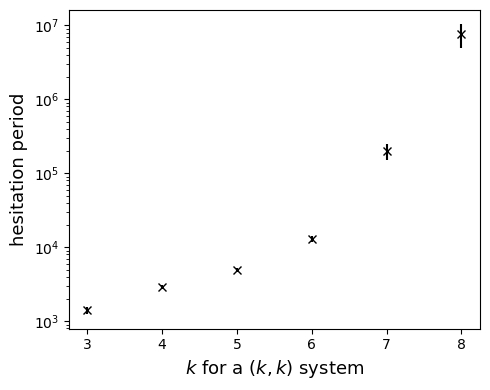

In [16]:
ks, avg_times, error_bars = np.loadtxt(filesdir+'(M,S)-dep-decision.txt', unpack=True) # k, avg_times, error_bars

# popt, pcov = curve_fit(exponential_quadr, ks, avg_times, sigma=error_bars)

# print(popt)

fig, ax = plt.subplots(tight_layout=True, figsize=figsize)
ax.errorbar(ks, avg_times, yerr=error_bars, marker='x', color='k', ls='none')
# ax.plot(ks, exponential_quadr(ks, *popt), 'r', lw=0.5)
ax.set_yscale('log')
ax.set_xlabel(f'$k$ for a $(k,k)$ system', fontsize=fontsize)
ax.set_ylabel('hesitation period', fontsize=fontsize)
fig.savefig(plotdir+'hesitation-(M,S).png', dpi=400)